# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/921a697d63e17c1cb86364faf0d309c7fe078fabf6f3e24be2cefa47.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Arlington, Virginia, United States**, and the stations the data comes from are shown on the map below.

In [1]:
# edited by Meixin Wang in July 20 2019. Copy of the code should show credit

import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(8,8))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

leaflet_plot_stations(400,'921a697d63e17c1cb86364faf0d309c7fe078fabf6f3e24be2cefa47')

In [2]:
import numpy as np
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/921a697d63e17c1cb86364faf0d309c7fe078fabf6f3e24be2cefa47.csv')
df.head()

,ID,Date,Element,Data_Value
0,USC00445204,2007-03-14,TMAX,250
1,USC00443204,2007-04-12,TMAX,133
2,USC00448737,2007-02-07,TMAX,-39
3,USW00003757,2014-08-08,TMIN,167
4,USW00003757,2014-12-14,TMAX,122


In [3]:
df_pivot = df.pivot_table(values='Data_Value', index=['ID','Date'], columns='Element')#, aggfunc=[np.min,np.max])
df_pivot = df_pivot.groupby(level = 1)['TMAX', 'TMIN'].agg({'TMAX': np.max, 'TMIN': np.min})
df_pivot.head()

,TMAX,TMIN
Date,,
2005-01-01,244.0,-11.0
2005-01-02,217.0,17.0
2005-01-03,211.0,28.0
2005-01-04,239.0,11.0
2005-01-05,233.0,39.0


In [4]:
# set timestamp as index and devide the period
df_pivot.index = pd.to_datetime(df_pivot.index)
before = df_pivot[df_pivot.index < '2015-01-01 00:00:00']
after = df_pivot[df_pivot.index >= '2015-01-01 00:00:00']

# agg before tempertatures by the day of the year
before['Day'] = list(before.index.map(lambda x: x.strftime('%m-%d')))
before = before.reset_index().groupby('Day')['TMAX','TMIN'].agg({'TMAX': np.max, 'TMIN': np.min})
# scale down the temperature
before = before/10
after = after/10
before.head()

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,TMAX,TMIN
Day,,
01-01,24.4,-6.7
01-02,21.7,-7.8
01-03,21.1,-11.1
01-04,23.9,-17.1
01-05,23.3,-17.1


In [5]:
after['Day'] = list(after.index.map(lambda x: x.strftime('%m-%d')))
after = after.reset_index().drop(['Date'], axis =1)
# insert data for 02-29 to compare with before data
line = pd.DataFrame({'Day': '02-29' ,'TMAX': 0, 'TMIN': 0}, index = [0]) 
after = after.append(line, ignore_index = True).set_index('Day').sort_index()
after.head()

,TMAX,TMIN
Day,,
01-01,8.3,-6.7
01-02,9.4,-5.6
01-03,8.3,-3.9
01-04,20.0,-4.4
01-05,20.0,-1.6


In [6]:
after['TMAX'][(after['TMAX'] <= before['TMAX'])] = np.nan
after['TMIN'][(after['TMIN'] >= before['TMIN'])] = np.nan
odds_high = after['TMAX'].values
odds_low = after['TMIN'].values
high_num = len(odds_high[~pd.isnull(odds_high)])
low_num = len(odds_high[~pd.isnull(odds_high)])

<IPython.core.display.Javascript object>


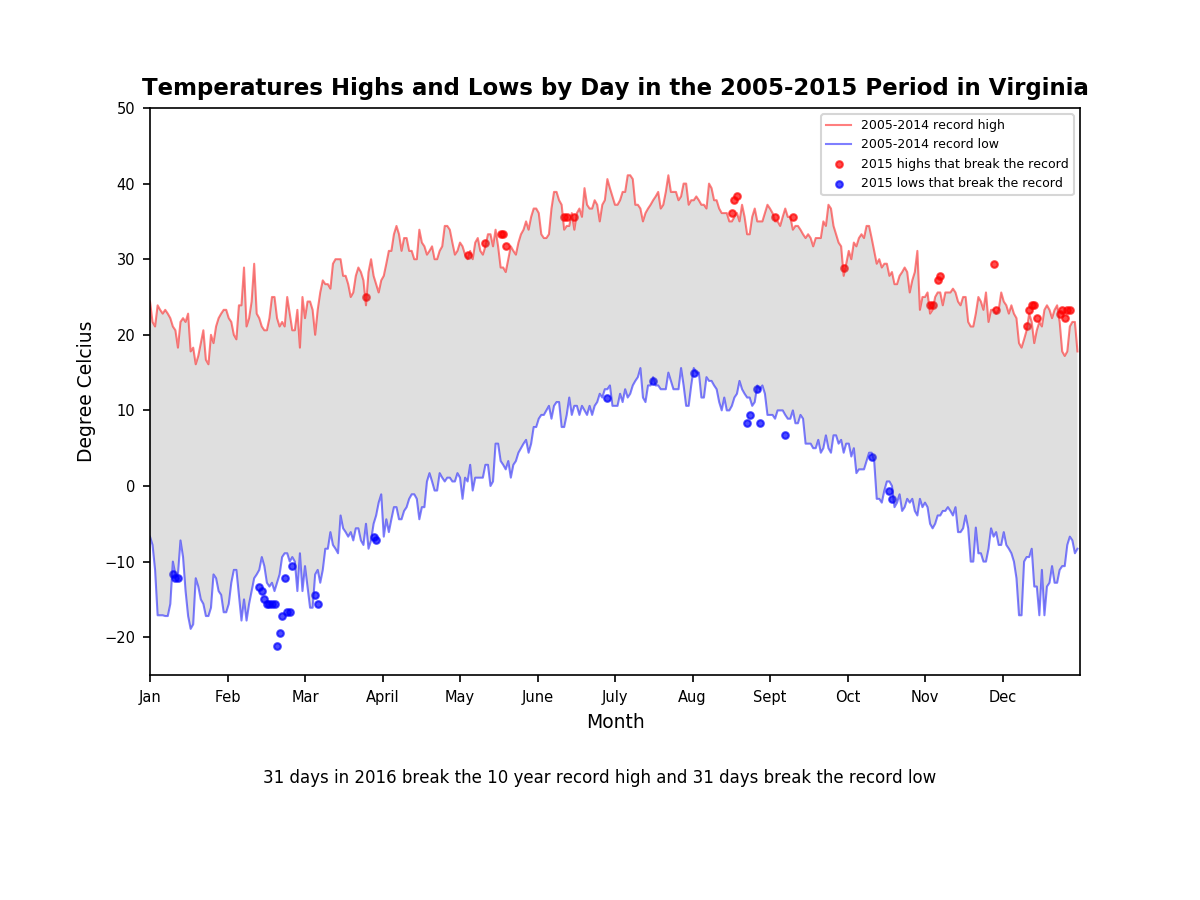

In [26]:
%matplotlib notebook

fig, ax = plt.subplots(1,1, figsize=(8,6))

#timestamp = before.index.values
#tick_stamp = timestamp[::26]  # subset of timestamp as x ticks
tick_stamp = ['Jan','Feb','Mar','April','May','June','July','Aug','Sept','Oct','Nov','Dec']
max_temp = before['TMAX'].values
min_temp = before['TMIN'].values

plt.plot(range(366),max_temp,'r-',alpha = 0.5, linewidth=1, label = '2005-2014 record high')
plt.plot(range(366),min_temp,'b-',alpha = 0.5, linewidth=1, label = '2005-2014 record low')
plt.scatter(range(366),odds_high, s = 10, c = 'red', alpha = 0.7, label = '2015 highs that break the record')
plt.scatter(range(366),odds_low, s = 10, c = 'blue', alpha = 0.7, label = '2015 lows that break the record')

# fill the area between the high and low lines
ax.fill_between(range(366), 
                       max_temp, min_temp, 
                       facecolor='gray',  
                       alpha=0.25)   # transparency value

# set ticks and labels
ax.set_xticks([x*30.5 for x in range(12)])  # 366/12
ax.set_xticklabels(tick_stamp)
ax.tick_params(axis='both', labelsize=7)

# add description
ax.set_title('Temperatures Highs and Lows by Day in the 2005-2015 Period in Virginia', fontsize=11, fontweight='bold', wrap=True)
ax.set_xlabel('Month', fontsize=9)                               # or plt.xlabel('Date')
ax.set_ylabel('Degree Celcius', fontsize=9)                              # plt.ylabel('Units')
plt.legend(loc=1, frameon=True, prop={'size': 6})
# center text
txt = '{} days in 2016 break the 10 year record high and {} days break the record low'.format(
high_num, low_num)
fig.text(.5, .13, txt, ha='center', fontsize=8)

# rotate the tick labels for the x axis
#x = ax.xaxis
#for item in x.get_ticklabels():
#    item.set_rotation(60)
    
# adjust the subplot so the text doesn't run off the image
plt.subplots_adjust(bottom=0.25)

# adjust space to the left/right/top/bottom of the plot
plt.xlim(0, 366)
plt.ylim(-25, 50)
    
plt.savefig("Temperature Record", ext='png', bbox_inches="tight")